<a href="https://colab.research.google.com/github/CesarSandoval714/Mineria-de-datos-CSVUEFA/blob/main/Ranking_de_Selecciones_de_futbok_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cesar Jaziel Sandoval Mata

1.Adquisición de datos

In [47]:
import requests
import io
import numpy as np
from math import sqrt
import random as rd
from bs4 import BeautifulSoup
import pandas as pd
from tabulate import tabulate
from typing import Tuple, List
from scipy import stats
import re
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.cluster import KMeans



def get_soup(url: str) -> BeautifulSoup:
    response = requests.get(url)
    return BeautifulSoup(response.content, 'html.parser')

def get_csv_from_url(url:str) -> pd.DataFrame:
    s=requests.get(url).content
    return pd.read_csv(io.StringIO(s.decode('utf-8')))

def print_tabulate(df: pd.DataFrame):
    print(tabulate(df, headers=df.columns, tablefmt='orgtbl'))


df = get_csv_from_url("https://raw.githubusercontent.com/CesarSandoval714/Mineria-de-datos-CSVUEFA/main/fifa_ranking-2021-05-27.csv")
df.head(1000)

,id,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,43818,82,Iraq,IRQ,15,0,0,AFC,31/12/1992
1,43873,107,Mozambique,MOZ,9,0,0,CAF,31/12/1992
2,43816,108,Indonesia,IDN,9,0,0,AFC,31/12/1992
3,1882218,109,Antigua and Barbuda,ATG,8,0,0,CONCACAF,31/12/1992
4,43820,110,Jordan,JOR,8,0,0,AFC,31/12/1992
...,...,...,...,...,...,...,...,...,...
995,43838,82,Syria,SYR,20,20,0,AFC,15/02/1994
996,43948,1,Germany,GER,59,59,0,UEFA,15/02/1994
997,43896,107,Barbados,BRB,12,11,7,CONCACAF,15/02/1994
998,43825,108,Lebanon,LBN,11,11,0,AFC,15/02/1994


Este dataset contiene: 

-**Id**: id de la seleción


-**Rank**: Ranking de la selección (o clasificación segun sus puntos) 

--**Country_full**: nombre completo de la selección 

--**Country_Abrv**: nombre abreviado de la selección

--**Total_points**: puntos obtenidos en ese registr

--**Previous_points**: puntos obtenidos el registro anterior

--**Rank_change**: diferencia de cambio en el ranking

--**Confederation**: Confederacion a la que pertenece la selección

--**rank_date**: fecha de registro del ranking de la seleccion

# 2. Limpieza de datos

In [45]:
df.shape

(63054, 9)

In [49]:
#se eliminan columnas irrelavantes

df = df.drop(columns = ['country_abrv']) 
df.head(1000)






,id,rank,country_full,total_points,previous_points,rank_change,confederation,rank_date
0,43818,82,Iraq,15,0,0,AFC,31/12/1992
1,43873,107,Mozambique,9,0,0,CAF,31/12/1992
2,43816,108,Indonesia,9,0,0,AFC,31/12/1992
3,1882218,109,Antigua and Barbuda,8,0,0,CONCACAF,31/12/1992
4,43820,110,Jordan,8,0,0,AFC,31/12/1992
...,...,...,...,...,...,...,...,...
995,43838,82,Syria,20,20,0,AFC,15/02/1994
996,43948,1,Germany,59,59,0,UEFA,15/02/1994
997,43896,107,Barbados,12,11,7,CONCACAF,15/02/1994
998,43825,108,Lebanon,11,11,0,AFC,15/02/1994


In [50]:
df.shape


(63054, 8)

In [51]:
df.isna().sum()


id                 0
rank               0
country_full       0
total_points       0
previous_points    0
rank_change        0
confederation      0
rank_date          0
dtype: int64



```
# Vemos que no contiene datos NaN
```



In [54]:
ranking_tabla = df['rank']
ranking_tabla



0         82
1        107
2        108
3        109
4        110
        ... 
63049    137
63050    136
63051    135
63052    159
63053      2
Name: rank, Length: 63054, dtype: int64

In [55]:
FechaRegistro_tabla = df['rank_date']
FechaRegistro_tabla

0        31/12/1992
1        31/12/1992
2        31/12/1992
3        31/12/1992
4        31/12/1992
            ...    
63049    27/05/2021
63050    27/05/2021
63051    27/05/2021
63052    27/05/2021
63053    27/05/2021
Name: rank_date, Length: 63054, dtype: object

In [62]:
Puntos_tabla = df['total_points']
Puntos_tabla

0          15
1           9
2           9
3           8
4           8
         ... 
63049    1088
63050    1089
63051    1091
63052    1020
63053    1757
Name: total_points, Length: 63054, dtype: int64

In [56]:
type(df)


pandas.core.frame.DataFrame

# 3.Analisis de datos

In [57]:
df.rank_date.unique()

array(['31/12/1992', '08/08/1993', '23/09/1993', '22/10/1993',
       '19/11/1993', '23/12/1993', '15/02/1994', '15/03/1994',
       '19/04/1994', '17/05/1994', '14/06/1994', '21/07/1994',
       '13/09/1994', '25/10/1994', '22/11/1994', '20/12/1994',
       '20/02/1995', '19/04/1995', '16/05/1995', '13/06/1995',
       '25/07/1995', '22/08/1995', '19/09/1995', '17/10/1995',
       '21/11/1995', '19/12/1995', '24/01/1996', '21/02/1996',
       '24/04/1996', '22/05/1996', '03/07/1996', '28/08/1996',
       '25/09/1996', '23/10/1996', '20/11/1996', '18/12/1996',
       '27/02/1997', '09/04/1997', '14/05/1997', '18/06/1997',
       '16/07/1997', '20/08/1997', '17/09/1997', '17/10/1997',
       '19/11/1997', '23/12/1997', '18/02/1998', '18/03/1998',
       '22/04/1998', '20/05/1998', '15/07/1998', '19/08/1998',
       '16/09/1998', '21/10/1998', '18/11/1998', '23/12/1998',
       '27/01/1999', '24/02/1999', '24/03/1999', '21/04/1999',
       '19/05/1999', '16/06/1999', '21/07/1999', '18/08

In [59]:
df.country_full.unique()

array(['Iraq', 'Mozambique', 'Indonesia', 'Antigua and Barbuda', 'Jordan',
       'Sudan', 'Mauritius', 'Croatia', 'Fiji', 'Barbados', 'Oman',
       'Guinea-Bissau', 'St. Lucia', 'Hong Kong', 'Panama', 'Grenada',
       'Puerto Rico', 'Yemen', 'St. Vincent / Grenadines', 'Swaziland',
       'Luxembourg', 'Ethiopia', 'Albania', 'Bolivia', 'Bahrain',
       'Singapore', 'Congo', 'Malaysia', 'Uganda', 'Lithuania',
       'Faroe Islands', 'Suriname', 'Syria', 'Burkina Faso', 'Latvia',
       'Burundi', 'Togo', 'Angola', 'Tahiti', 'Liberia', 'South Africa',
       'San Marino', 'Nepal', 'Gambia', 'Equatorial Guinea', 'Myanmar',
       'Liechtenstein', 'Nicaragua', 'Chad', 'Central African Republic',
       'Chinese Taipei', 'Namibia', 'Vanuatu', 'Aruba', 'Lebanon',
       'Bahamas', 'Maldives', 'Rwanda', 'Philippines', 'Seychelles',
       'Belarus', 'Pakistan', 'Benin', 'Guyana', 'Ukraine', 'Haiti',
       'Slovenia', 'Estonia', 'Bangladesh', 'Mauritania', 'Cabo Verde',
       'Solomon Is

In [63]:
gender_frame = pd.DataFrame(data=df['total_points'])
gender_frame 
x=max(Puntos_tabla)
y=min(Puntos_tabla)
z= df["total_points"].mean()
w=df["total_points"].median()
m = df["total_points"].mode()
r=df["total_points"].count()
s=df["total_points"].sum()
k=df["total_points"].kurtosis()
v=df["total_points"].var()
d=df["total_points"].std()
print("Max {0}\n Min {1}\n Promedio {2}\n Mediana {3}\n moda {4}\n Conteo {5}\n Suma {6}\n Kutosis {7}\n Varianza {8}\n Desviacion Estandar {9}\n".format(x,y,z,w,m,r,s,k,v,d))

Max 2172
 Min 0
 Promedio 407.70282614901515
 Mediana 320.0
 moda 0    0
dtype: int64
 Conteo 63054
 Suma 25707294
 Kutosis 0.8644781858466266
 Varianza 149982.4309002977
 Desviacion Estandar 387.27565234635875



In [64]:
g = df.groupby(['country_full','rank', 'total_points','rank_date']).mean()
g

id  previous_points  \
country_full rank total_points rank_date                              
Afghanistan  122  226          10/04/2014  20000.0            213.0   
             127  213          13/03/2014  20000.0            184.0   
             128  204          08/05/2014  20000.0            226.0   
             129  217          14/08/2014  20000.0            217.0   
                               17/07/2014  20000.0            215.0   
...                                            ...              ...   
Zimbabwe     127  281          07/04/2016  43892.0            271.0   
             129  213          13/04/2011  43892.0            214.0   
             131  197          16/10/2009  43892.0            259.0   
                  266          04/02/2016  43892.0            322.0   
                  271          03/03/2016  43892.0            266.0   

                                           rank_change  
country_full rank total_points rank_date                
Afghanistan  122  226          10/04/2014          5.0  
             127  213          13/03/2014         11.0  
             128  204          08/05/2014          6.0  
             129  217          14/08/2014          0.0  
                               17/07/2014          1.0  
...                                                ...  
Zimbabwe     127  281          07/04/2016          4.0  
             129  213          13/04/2011          2.0  
             131  197          16/10/2009         11.0  
                  266          04/02/2016         23.0  
                  271          03/03/2016          0.0  

[63054 rows x 3 columns]

In [65]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63054 entries, 0 to 63053
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               63054 non-null  int64 
 1   rank             63054 non-null  int64 
 2   country_full     63054 non-null  object
 3   total_points     63054 non-null  int64 
 4   previous_points  63054 non-null  int64 
 5   rank_change      63054 non-null  int64 
 6   confederation    63054 non-null  object
 7   rank_date        63054 non-null  object
dtypes: int64(5), object(3)
memory usage: 3.8+ MB


#4. Graficación 

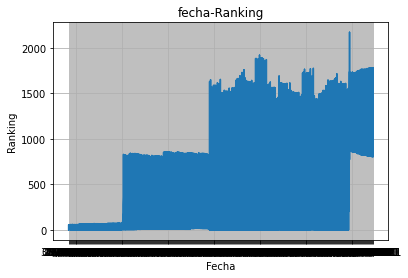

In [70]:
plt.plot(df['rank_date'], df['total_points'], label='total_points')


plt.xlabel('Fecha')
plt.ylabel('Puntos')
plt.title('fecha-Puntos')
plt.grid(True)

<BarContainer object of 63054 artists>

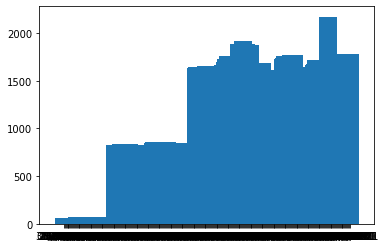

In [71]:
plt.bar(df['rank_date'], df['total_points'], width=20)

In [72]:
fig = go.Figure()

fig.add_trace(go.Bar(x=df['country_full'], y=df['total_points']))

fig.update_layout(
    xaxis=dict(
        title_text='country_full',
        titlefont=dict(size=30),
    ),
    yaxis=dict(
        title_text='total_points',
        
        titlefont=dict(size=30)
    ),
    title="Acumulado de Ranking de cada seleción"
)

fig.show()

In [76]:
fig = go.Figure()

fig.add_trace(go.Bar(x=df['confederation'], y=df['total_points'], marker = {'color' : 'red'}))

fig.update_layout(
    xaxis=dict(
        title_text='confederation',
        titlefont=dict(size=30),
    ),
    yaxis=dict(
        title_text="total_points",
        
        titlefont=dict(size=30)
    ),
    title="Acumulado de Ranking segun cada federacion"
)

fig.show()

In [ ]:
sns.pairplot(datePrice, hue="fuel")


# 5.Prueba de Hipotesis

In [36]:
SalarioJugSwitzerland = df.wage_euro[df.nationality =='Switzerland']
SalarioJugColombia = df.wage_euro[df.nationality =='Colombia']


from scipy import stats
anova = stats.f_oneway(SalarioJugColombia, SalarioJugSwitzerland)
anova


F_onewayResult(statistic=26.416872865970795, pvalue=3.52414026768248e-07)

In [27]:
df.nationality.unique()

array(['Argentina', 'Denmark', 'France', 'Italy', 'Senegal',
       'Netherlands', 'Germany', 'Uruguay', 'Spain', 'Belgium', 'Egypt',
       'Slovakia', 'Brazil', 'Croatia', 'Costa Rica', 'Morocco',
       'Colombia', 'Sweden', 'Bosnia Herzegovina', 'Portugal', 'Mexico',
       'England', 'Austria', 'Iceland', 'Hungary', 'Wales', 'Ukraine',
       'Central African Rep.', 'Serbia', 'Ivory Coast', 'Cameroon',
       'Paraguay', 'Australia', 'Algeria', 'Romania', 'Russia', 'Israel',
       'Switzerland', 'Chile', 'Tunisia', 'Turkey', 'Nigeria', 'Norway',
       'Greece', 'Peru', 'United States', 'Iran', 'Equatorial Guinea',
       'Cape Verde', 'Tanzania', 'Scotland', 'China PR', 'Kosovo',
       'Montenegro', 'Canada', 'Madagascar', 'Mali', 'Guinea', 'Poland',
       'Cuba', 'Northern Ireland', 'Ghana', 'Japan', 'New Zealand',
       'Burkina Faso', 'Czech Republic', 'Slovenia', 'Belarus', 'Ecuador',
       'Gabon', 'FYR Macedonia', 'Curacao', 'DR Congo', 'Honduras',
       'Sierra Leone

In [32]:
stats.ttest_ind(df.wage_euro.loc[df.nationality=='Switzerland'],
                df.wage_euro.loc[df.nationality=='Colombia'],nan_policy='omit')

Ttest_indResult(statistic=5.139734707742296, pvalue=3.524140267682724e-07)

In [39]:
fig = go.Figure()
# Hipotesis de que los jugadores de Colombia ganan mas en promedio que los de Suiza 
fig.add_trace(go.Box(y=df.wage_euro.loc[df.nationality=='Colombia'],name="COLOMBIA"))
fig.add_trace(go.Box(y=df.wage_euro.loc[df.nationality=='Switzerland'],name="SUIZA"))
fig.update_layout(
    title={
        'text': "     Promedio de ganancia de jugadores COLOMBIA-SUIZA",
        'y':0.8,
        'x':0.4,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

# 6.Regresion lineal

Text(0.5, 1.0, 'Regresion Lineal añoContratacion-Valor jugador')

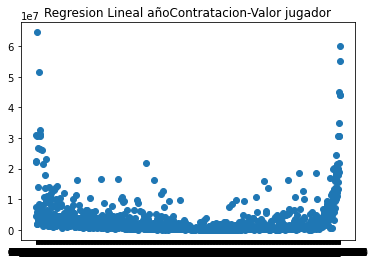

In [40]:
contratacionValor = pd.DataFrame()
contratacionValor['club_join_date'] = df['club_join_date']
contratacionValor ['value_euro']= df['value_euro']

contratacionValor = contratacionValor.groupby(pd.Grouper(key='club_join_date')).mean().reset_index()
contratacionValor=contratacionValor.reset_index()

modelo = LinearRegression().fit(contratacionValor['index'].values.reshape((-1,1)), contratacionValor['value_euro'])

meanLine = [[df['value_euro'].mean()],[df['value_euro'].mean()]]

plt.scatter(contratacionValor['club_join_date'], contratacionValor['value_euro'])
plt.title("Regresion Lineal TerminacionContra-Valor jugador")

Text(0.5, 1.0, 'Regresion Lineal TerminacionContrato-Valor jugador')

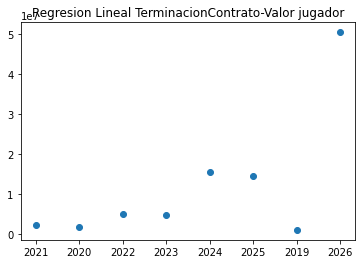

In [42]:
contratacionValor = pd.DataFrame()
contratacionValor['contract_end_year'] = df['contract_end_year']
contratacionValor ['value_euro']= df['value_euro']

contratacionValor = contratacionValor.groupby(pd.Grouper(key='contract_end_year')).mean().reset_index()
contratacionValor=contratacionValor.reset_index()

modelo = LinearRegression().fit(contratacionValor['index'].values.reshape((-1,1)), contratacionValor['value_euro'])

meanLine = [[df['value_euro'].mean()],[df['value_euro'].mean()]]

plt.scatter(contratacionValor['contract_end_year'], contratacionValor['value_euro'])
plt.title("Regresion Lineal TerminacionContrato-Valor jugador")

Text(0.5, 1.0, 'Regresion Lineal Calificacion-Valor jugador')

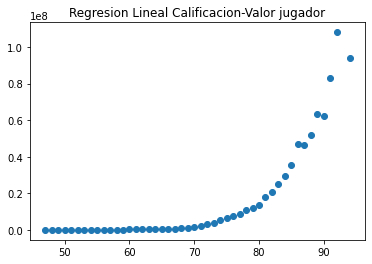

In [43]:
contratacionValor = pd.DataFrame()
contratacionValor['overall_rating'] = df['overall_rating']
contratacionValor ['value_euro']= df['value_euro']

contratacionValor = contratacionValor.groupby(pd.Grouper(key='overall_rating')).mean().reset_index()
contratacionValor=contratacionValor.reset_index()

modelo = LinearRegression().fit(contratacionValor['index'].values.reshape((-1,1)), contratacionValor['value_euro'])

meanLine = [[df['value_euro'].mean()],[df['value_euro'].mean()]]

plt.scatter(contratacionValor['overall_rating'], contratacionValor['value_euro'])
plt.title("Regresion Lineal Calificacion-Valor jugador")

In [ ]:
datePrice = pd.DataFrame()
datePrice['year'] = df['year']
datePrice ['price']= df['price']

datePrice = datePrice.groupby(pd.Grouper(key='year')).mean().reset_index()
datePrice=datePrice.reset_index()


modelo = LinearRegression().fit(datePrice['index'].values.reshape((-1,1)), datePrice['price'])

meanLine = [[df['price'].mean()],[df['price'].mean()]]

plt.scatter(datePrice['year'], datePrice['price'])
plt.plot([[1940],[2022]], modelo.predict([[0],[50]]), color = 'red')
plt.plot([[1940],[2022]], meanLine, color = 'green')

plt.title("Regresion Lineal año-precio")